# Finetune moondream: advanced techniques

This notebook demonstrates how to fine-tune moondream to improve performance on a downstream task. 

## Import packages

In [1]:
%pip install torch transformers timm einops datasets bitsandbytes accelerate torchvision Pillow optuna flash_attn wandb

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Read datasets

The following step helps you load and optionally augment datasets like [Screen2words](https://huggingface.co/datasets/HuggingFaceM4/the_cauldron/viewer/screen2words), [deepfashion-multimodal](https://huggingface.co/datasets/Marqo/deepfashion-multimodal), [playingcards_roboflow](https://huggingface.co/datasets/tukey/playingcards_roboflow), and [Plastic detection](https://huggingface.co/datasets/tukey/plastic_detection_roboflow). When augment = True, transformations such as random horizontal flips, rotations, color jitter, and resizing are applied to the training data to improve model performance. You can select the dataset, specify the percentage of data to use, and apply augmentations with the choose_dataset() function. Validation and test data remain unchanged, ensuring accurate performance evaluation.

In [1]:
from torch.utils.data import Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision.transforms as transforms
from PIL import Image

# Define a function that applies transformations (data augmentation), including multiple rotations
def get_augmentation_transforms():
    return transforms.Compose([
        transforms.RandomApply([
            transforms.RandomRotation((0, 90))
        ], p=0.5),  
    ])


In [3]:
class Screen2WordsDataset(Dataset):
    def __init__(self, split='train', val_size=0.1, test_size=0.2, random_state=42, data_percentage=1.0, augment=False):
        # Load the entire dataset
        self.data = load_dataset("HuggingFaceM4/the_cauldron", name="screen2words")['train']
        
        # Calculate the number of samples to use based on the data_percentage
        n_samples = int(len(self.data) * data_percentage)
        if n_samples < 1:
            raise ValueError("data_percentage results in too few samples. Increase the percentage.")

        # Use only the specified percentage of the data
        self.data = self.data.select(list(range(n_samples)))

        # First, split the dataset into train + temp (temp will later be split into validation and test)
        train_indices, temp_indices = train_test_split(
            list(range(len(self.data))), test_size=val_size + test_size, random_state=random_state
        )

        # Then, split the temp_indices into validation and test sets
        val_split_ratio = val_size / (val_size + test_size)  # Ratio of temp that should go to validation
        val_indices, test_indices = train_test_split(
            temp_indices, test_size=1 - val_split_ratio, random_state=random_state
        )

        # Select the appropriate split
        if split == 'train':
            self.data = self.data.select(train_indices)
            self.transform = get_augmentation_transforms() if augment else transforms.Compose([])  # No transformation if augment is False
        elif split == 'val':
            self.data = self.data.select(val_indices)
            self.transform = transforms.Compose([])
        elif split == 'test':
            self.data = self.data.select(test_indices)
            self.transform = transforms.Compose([])
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample["images"][0] 
        image = self.transform(image) 
    
            
        return {
            "image": image,
            "qa": [
                {
                    "question": sample["texts"][0]["user"],
                    "answer": sample["texts"][0]["assistant"], 
                }
            ]
        }


In [4]:
class PlayingCardsDataset(Dataset):
    def __init__(self, split='train', val_size=0.1, test_size=0.2, random_state=42, data_percentage=1.0, augment=False):
        # Load the entire dataset
        self.data = load_dataset("tukey/playingcards_roboflow")['train']
        
        # Calculate the number of samples to use based on the data_percentage
        n_samples = int(len(self.data) * data_percentage)
        if n_samples < 1:
            raise ValueError("data_percentage results in too few samples. Increase the percentage.")

        # Use only the specified percentage of the data
        self.data = self.data.select(list(range(n_samples)))

        # First, split the dataset into train + temp (temp will later be split into validation and test)
        train_indices, temp_indices = train_test_split(
            list(range(len(self.data))), test_size=val_size + test_size, random_state=random_state
        )

        # Then, split the temp_indices into validation and test sets
        val_split_ratio = val_size / (val_size + test_size)  # Ratio of temp that should go to validation
        val_indices, test_indices = train_test_split(
            temp_indices, test_size=1 - val_split_ratio, random_state=random_state
        )

        # Select the appropriate split and assign the transformations
        if split == 'train':
            self.data = self.data.select(train_indices)
            self.transform = get_augmentation_transforms() if augment else transforms.Compose([])
        elif split == 'val':
            self.data = self.data.select(val_indices)
            self.transform = transforms.Compose([])
        elif split == 'test':
            self.data = self.data.select(test_indices)
            self.transform = transforms.Compose([])
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample["image"] 
        image = self.transform(image) 
            
        return {
            "image": image,
            "qa": [
                {
                    "question": sample["qa"][0]["question"],
                    "answer": sample["qa"][0]["answer"],  
                }
            ]
        }

In [5]:
class DeepFashionDataset(Dataset):
    def __init__(self, split='train', val_size=0.1, test_size=0.2, random_state=42, data_percentage=1.0, augment=False):
        # Load the entire dataset
        self.data = load_dataset("Marqo/deepfashion-multimodal")['data']
        
        # Calculate the number of samples to use based on the data_percentage
        n_samples = int(len(self.data) * data_percentage)
        if n_samples < 1:
            raise ValueError("data_percentage results in too few samples. Increase the percentage.")

        # Use only the specified percentage of the data
        self.data = self.data.select(list(range(n_samples)))

        # First, split the dataset into train + temp (temp will later be split into validation and test)
        train_indices, temp_indices = train_test_split(
            list(range(len(self.data))), test_size=val_size + test_size, random_state=random_state
        )

        # Then, split the temp_indices into validation and test sets
        val_split_ratio = val_size / (val_size + test_size)  # Ratio of temp that should go to validation
        val_indices, test_indices = train_test_split(
            temp_indices, test_size=1 - val_split_ratio, random_state=random_state
        )

        # Select the appropriate split and assign the transformations
        if split == 'train':
            self.data = self.data.select(train_indices)
            self.transform = get_augmentation_transforms() if augment else transforms.Compose([])  # No transformation if augment is False
        elif split == 'val':
            self.data = self.data.select(val_indices)
            self.transform = transforms.Compose([])
        elif split == 'test':
            self.data = self.data.select(test_indices)
            self.transform = transforms.Compose([])
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample["image"]  
        image = self.transform(image)  
            
        return {
            "image": image,
            "qa": [
                {
                    "question": "What is the person wearing?",
                    "answer": sample["text"], 
                }
            ]
        }

In [6]:
import random 

class PlasticDetectionDataset(Dataset):
    def __init__(self, split='train', val_size=0.1, test_size=0.2, random_state=42, data_percentage=1.0, augment=False):
        # Load the entire dataset
        self.data = load_dataset("tukey/plastic_detection_roboflow")['train']
        
        # Calculate the number of samples to use based on the data_percentage
        n_samples = int(len(self.data) * data_percentage)
        if n_samples < 1:
            raise ValueError("data_percentage results in too few samples. Increase the percentage.")

        # Use only the specified percentage of the data
        self.data = self.data.select(list(range(n_samples)))

        # First, split the dataset into train + temp (temp will later be split into validation and test)
        train_indices, temp_indices = train_test_split(
            list(range(len(self.data))), test_size=val_size + test_size, random_state=random_state
        )

        # Then, split the temp_indices into validation and test sets
        val_split_ratio = val_size / (val_size + test_size)  # Ratio of temp that should go to validation
        val_indices, test_indices = train_test_split(
            temp_indices, test_size=1 - val_split_ratio, random_state=random_state
        )

        # Select the appropriate split and assign the transformations
        if split == 'train':
            self.data = self.data.select(train_indices)
            self.transform = get_augmentation_transforms() if augment else transforms.Compose([])  # No transformation if augment is False
        elif split == 'val':
            self.data = self.data.select(val_indices)
            self.transform = transforms.Compose([])
        elif split == 'test':
            self.data = self.data.select(test_indices)
            self.transform = transforms.Compose([])
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample["image"]  
        image = self.transform(image) 

        # Randomly select one QA pair from the available list of QA pairs
        qa_pairs = sample["qa"]
        selected_qa = random.choice(qa_pairs) 
            
        return {
            "image": image,
            "qa": [selected_qa] 
        }


In [7]:
def choose_dataset(dataset_name="datasets_screen2words", data_percentage=1.0, augment=False):
    # Define the dataset constructors with data_percentage and augment parameter
    datasets = {
        "datasets_screen2words": {
            "train": Screen2WordsDataset(split="train", data_percentage=data_percentage, augment=augment),
            "val": Screen2WordsDataset(split="val", data_percentage=data_percentage),  # Validation dataset
            "test": Screen2WordsDataset(split="test", data_percentage=data_percentage),
        },
        "datasets_playingcards": {
            "train": PlayingCardsDataset(split="train", data_percentage=data_percentage, augment=augment),
            "val": PlayingCardsDataset(split="val", data_percentage=data_percentage),  # Validation dataset
            "test": PlayingCardsDataset(split="test", data_percentage=data_percentage),
        },
        "datasets_deepfashion": {
            "train": DeepFashionDataset(split="train", data_percentage=data_percentage, augment=augment),
            "val": DeepFashionDataset(split="val", data_percentage=data_percentage),  # Validation dataset
            "test": DeepFashionDataset(split="test", data_percentage=data_percentage),
        },
        "datasets_plastic_detection": {
            "train": PlasticDetectionDataset(split="train", data_percentage=data_percentage, augment=augment),
            "val": PlasticDetectionDataset(split="val", data_percentage=data_percentage),  # Validation dataset
            "test": PlasticDetectionDataset(split="test", data_percentage=data_percentage),
        }
    }

    # If the dataset name exists in available datasets, return it
    if dataset_name in datasets:
        return datasets[dataset_name]
    else:
        print(f"Dataset '{dataset_name}' not found. Using default 'datasets_screen2words'.")
        return datasets["datasets_screen2words"]  # Default dataset

# Example usage with data augmentation for training:
datasets = choose_dataset("datasets_playingcards", data_percentage=1, augment=True)


## Initial testing

Now, let's look at some sample images and test the pretrained moondream model. First, set the device to "cuda" for GPUs, "mps" for M1 Macs, or "cpu" if you don't have a GPU, but note that fine-tuning on CPU is slow. The Moondream model and tokenizer are loaded using pre-trained weights, and flash attention is enabled for CUDA devices to optimize performance. Once initialized, you can pass an image and its corresponding question to the model to generate answers. Sample outputs, including the original image, question, ground truth, and model predictions, are displayed for evaluation.

In [8]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.
import PIL
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-08-26"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

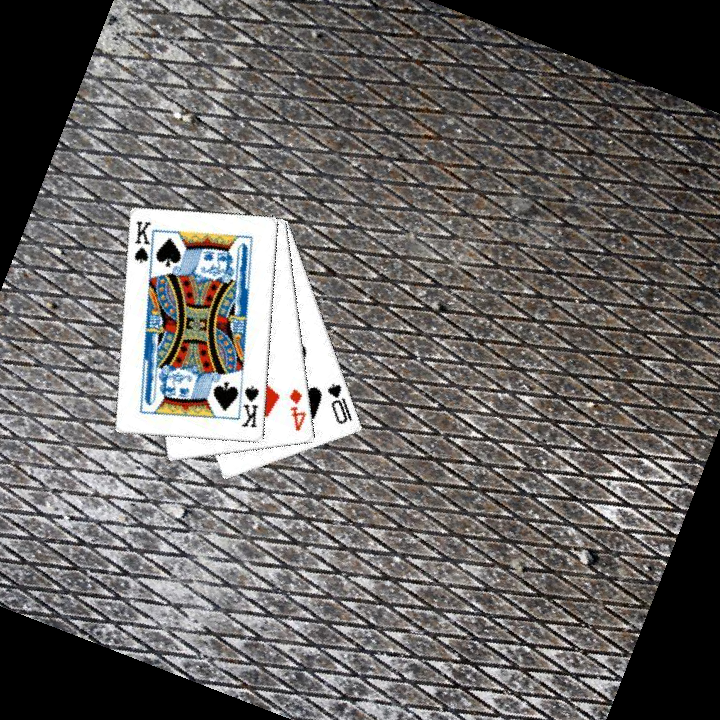

Question: what cards are in the image?
Ground Truth: 4 of diamond, 10 of spade, K of spade
Moondream: The image features a King of Spades playing card.


In [9]:
from IPython.display import display

sample = datasets['train'][58]
display(sample['image'])

for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    print('Moondream:', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

## Finetuning moondream

Now let's finetune the model. The following code outlines the process of fine-tuning the Moondream model and performing hyperparameter tuning using Optuna to minimize validation loss. You can decide number of epochs (EPOCHS), batch size (BATCH), gradient accumulation steps (GRAD_ACCUM_STEPS), and learning rate (LR) in the objective(trial) function. You can also set the number of trials for hyperparameter tuning.

In [10]:
import optuna
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm
import torch.optim as optim
import wandb
import functools

torch.cuda.empty_cache()

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

# Learning rate for the Adam optimizer. 
LR = 1e-5

USE_WANDB = True  # Enable W&B tracking

def collate_fn(batch, moondream, tokenizer):
    images = [sample['image'] for sample in batch]
    images = [moondream.vision_encoder.preprocess(image) for image in images]

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch, moondream):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder(images)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

# Define the objective function that Optuna will optimize
def objective(trial):
    moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE, device_map={"": DEVICE})
    
    # Suggest hyperparameters to tune
    EPOCHS = trial.suggest_int('EPOCHS', 1, 1)  # Tune between 1 and 2 epochs
    LR = trial.suggest_loguniform('LR', 1e-6, 1e-4)  # Learning rate
    BATCH_SIZE = 8
    GRAD_ACCUM_STEPS = trial.suggest_categorical('BATCH_SIZE', [8]) // BATCH_SIZE

    collate_fn_with_moondream = functools.partial(collate_fn, moondream=moondream, tokenizer = tokenizer)

    # DataLoader with suggested batch size
    dataloaders = {
        "train": DataLoader(
            datasets["train"],
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_fn_with_moondream,
        ),
        "val": DataLoader(
            datasets["val"],
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn_with_moondream,
        )
    }

    moondream.text_model.train()

    total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
    optimizer = Adam8bit(
        [
            {"params": moondream.text_model.parameters()},
        ],
        lr=LR * 0.1,
        betas=(0.9, 0.95),
        eps=1e-6
    )

    i = 0
    for epoch in range(EPOCHS):
        
        for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
            i += 1
            loss = compute_loss(batch, moondream)
            loss.backward()

            if i % GRAD_ACCUM_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()

                lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            # Report intermediate loss to Optuna
            trial.report(loss.item(), epoch)

            # Prune the trial if needed
            if trial.should_prune():
                raise optuna.TrialPruned()

            # Log metrics during training if using W&B
            if USE_WANDB:
                wandb.log({
                    "epoch": epoch + 1,
                    "loss/train": loss.item(),
                    "lr": optimizer.param_groups[0]['lr']
                })

    
    # Evaluate the model on validation set
    moondream.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloaders["val"]:
            loss = compute_loss(batch, moondream)
            total_loss += loss.item()
    return total_loss / len(dataloaders["val"])
    # return val_loss

# Optuna optimization
study = optuna.create_study(direction="minimize") 

study.optimize(objective, n_trials=5)  

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_trial.params)
wandb.finish()  # Finalize the W&B run


## Model evaluation

In this step, we first select the best model parameters, train the model, and then evaluate the model. The model evaluation process uses multiple metrics (precision, recall, F-1 score, exact match accuracy, Jaccard similarity) to assess performance. The F1 Score evaluates precision and recall, giving a balanced measure of model performance based on exact matches of card rank and suit. The Jaccard Similarity computes the intersection over the union of the predicted and actual cards, while the Exact Match Accuracy checks whether the entire prediction exactly matches the ground truth without any deviation. During evaluation, predictions are compared with the ground truth, and these metrics are calculated for each sample. 

In [11]:
import wandb
import optuna
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm
import torch.optim as optim
import wandb
import functools

# Initialize W&B run
wandb.init(
    project="moondream",
    config={
        "epochs": study.best_trial.params['EPOCHS'],
        "batch_size": study.best_trial.params['BATCH_SIZE'],
        "learning_rate": study.best_trial.params['LR'],
        "optimizer_type": "Adam",  # Default optimizer
        "grad_accum_steps": BATCH_SIZE // 8
    }
)
config = wandb.config

# Extract the best hyperparameters
LR = study.best_trial.params['LR']
EPOCHS = study.best_trial.params['EPOCHS']
BATCH_SIZE = study.best_trial.params['BATCH_SIZE']
GRAD_ACCUM_STEPS = BATCH_SIZE // 8

moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

collate_fn_with_moondream = functools.partial(collate_fn, moondream=moondream, tokenizer = tokenizer)

# Create the DataLoader for the training dataset using the best batch size
dataloaders = {
        "train": DataLoader(
            datasets["train"],
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_fn_with_moondream,
        ),
        "val": DataLoader(
            datasets["val"],
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn_with_moondream,
        )
    }

# Reconfigure the model based on the best hyperparameters
moondream.text_model.train()  # Model should be in training mode for final re-training

# Retrain the model using the best hyperparameters if needed
optimizer = optim.Adam(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

# Re-train using the best hyperparameters
total_steps = EPOCHS * len(dataloaders['train']) // GRAD_ACCUM_STEPS

i = 0
for epoch in range(EPOCHS):
    loss_train_total = 0
    for batch in tqdm(dataloaders['train'], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1
        loss = compute_loss(batch, moondream)
        loss_train_total += loss.item()
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

    # Evaluate the model on validation set after each epoch
    moondream.eval()
    val_loss_total = 0 
    with torch.no_grad():
        for batch in dataloaders["val"]:
            val_loss = compute_loss(batch, moondream)
            val_loss_total += val_loss.item()
    
    # Log metrics during training if using W&B
    if USE_WANDB:
        wandb.log({
            "epoch": epoch + 1,
            "loss/train": loss_train_total / len(dataloaders["train"]),
            "loss/valid": val_loss_total / len(dataloaders["val"]),  # Ensure naming consistency
            "lr": optimizer.param_groups[0]['lr']
        })
    
wandb.finish()  # Finalize the W&B run

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yuanjietu (yuanjietu-university-of-washington). Use `wandb login --relogin` to force relogin


Epoch 1/10: 100%|██████████| 884/884 [10:18<00:00,  1.43it/s]
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/internal/generation_utils#transformers.Cache)
Epoch 10/10: 100%|██████████| 884/884 [10:18<00:00,  1.43it/s]


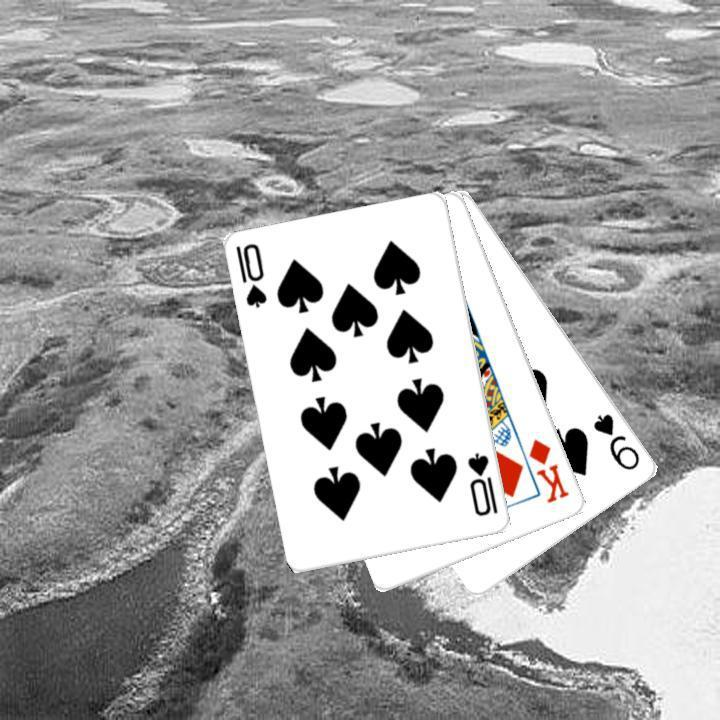

Question: what cards are in the image?
Ground Truth: ['9 of spade', '10 of spade', 'K of diamond']
Moondream Prediction: ['9 of spade', '10 of spade', 'K of diamond']
Precision: 1.000, Recall: 1.000, F1 Score: 1.000, Jaccard: 1.000, Exact Match: Yes
--------------------------------------------------


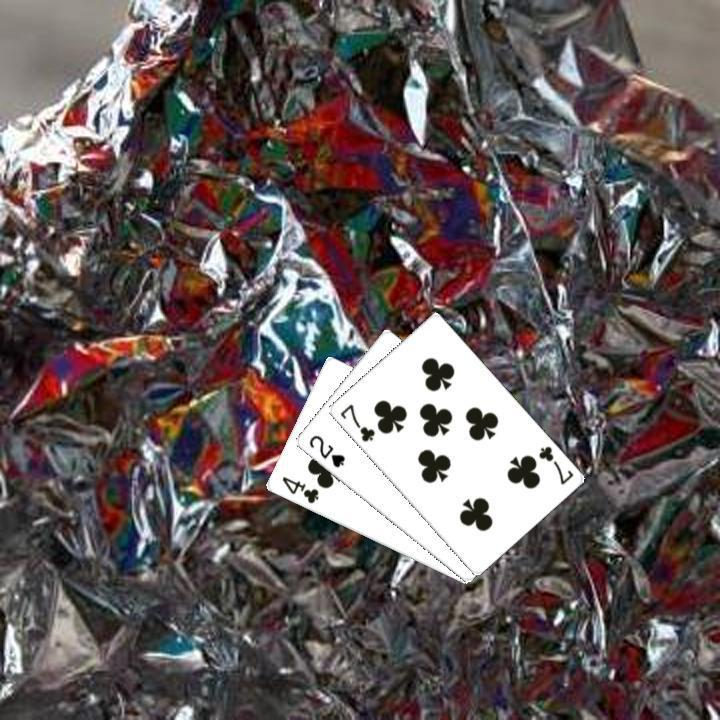

Question: what cards are in the image?
Ground Truth: ['2 of spade', '4 of club', '7 of club']
Moondream Prediction: ['2 of spade', '4 of club', '7 of club']
Precision: 1.000, Recall: 1.000, F1 Score: 1.000, Jaccard: 1.000, Exact Match: Yes
--------------------------------------------------


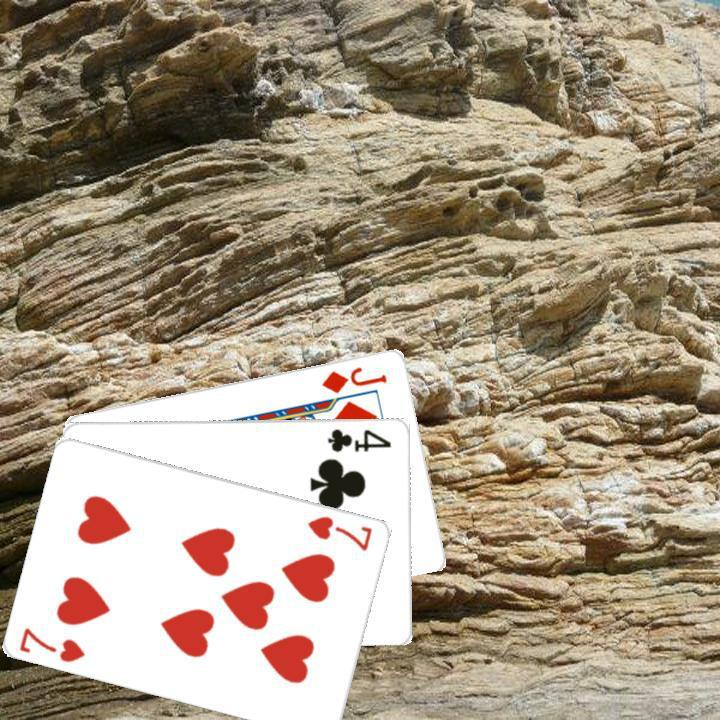

Question: what cards are in the image?
Ground Truth: ['4 of club', '7 of heart', 'J of diamond']
Moondream Prediction: ['4 of club', '7 of heart', 'J of diamond']
Precision: 1.000, Recall: 1.000, F1 Score: 1.000, Jaccard: 1.000, Exact Match: Yes
--------------------------------------------------

Evaluation Results:
Average Precision: 0.981
Average Recall: 0.981
Average F1 Score: 0.980
Average Jaccard Similarity: 0.970
Average Exact Match: 0.937


In [12]:
import re
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# F1 Score function
def plot_confusion_matrix(all_ground_truth, all_predictions, title="Confusion Matrix"):
    unique_labels = sorted(list(set(all_ground_truth + all_predictions)))  # Get unique labels from ground truth and predictions
    
    # Compute confusion matrix
    cm = confusion_matrix(all_ground_truth, all_predictions, labels=unique_labels)
    
    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(title)
    plt.show()

# F1 Score function
def f1_score(ground_truth, prediction):
    """
    Calculate F1 Score without partial credit for a single case.
    Full credit only for exact matches of rank and suit.
    """
    true_positives = 0

    gt_cards = set(ground_truth)
    pred_cards = set(prediction)

    matched_gt = set()
    matched_pred = set()

    for pred_card in pred_cards:
        if pred_card in gt_cards:
            true_positives += 1
            matched_gt.add(pred_card)
            matched_pred.add(pred_card)

    total_pred = len(pred_cards)
    total_gt = len(gt_cards)

    precision = true_positives / total_pred if total_pred > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0

    if precision + recall == 0:
        f1_score_value = 0
    else:
        f1_score_value = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score_value

# Jaccard Similarity function
def jaccard_similarity(ground_truth, prediction):
    intersection = 0

    gt_cards = set(ground_truth)
    pred_cards = set(prediction)

    for pred_card in pred_cards:
        if pred_card in gt_cards:
            intersection += 1  # Full match

    union = len(gt_cards.union(pred_cards))
    jaccard = intersection / union if union > 0 else 0

    return jaccard

# Exact Match Accuracy function
def exact_match_accuracy(ground_truth, prediction):
    gt_cards = set(ground_truth)
    pred_cards = set(prediction)

    return 1 if gt_cards == pred_cards else 0

# Function to parse cards from the ground truth and predictions
def parse_cards(answer):
    # Strip any leading or trailing spaces
    answer = answer.strip()
    
    # Split the string by commas and strip each card to remove leading/trailing spaces
    cards = [card.strip() for card in answer.split(',')]
    
    return cards

# Evaluation function that computes F1, Jaccard, and Exact Match in parallel
def evaluate_moondream(dataloader, moondream, tokenizer, num_samples_to_display=3, plot_confusion_m = False):
    
    moondream.eval()

    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_jaccard = 0
    total_exact_matches = 0
    num_samples = len(dataloader)
    
    # Lists to collect all ground truth and predicted values for confusion matrix
    all_ground_truth = []
    all_predictions = []

    for i, sample in enumerate(dataloader):
        sample_total_precision = 0
        sample_total_recall = 0
        sample_total_f1 = 0
        sample_total_jaccard = 0
        sample_total_exact_matches = 0
        
        num_questions = len(sample['qa'])

        if i < num_samples_to_display:
            # Display the image only for the first 'num_samples_to_display' samples
            display(sample['image'])
        
        for qa in sample['qa']:
            # Generate model's prediction for each question
            md_answer = moondream.answer_question(
                moondream.encode_image(sample['image']),
                qa['question'],
                tokenizer=tokenizer,
                num_beams=4,
                no_repeat_ngram_size=5,
                early_stopping=True
            )

            # Process ground truth and prediction to get lists of card labels
            ground_truth = parse_cards(qa['answer'])
            prediction = parse_cards(md_answer)

            # Append the ground truth and prediction to lists for confusion matrix
            all_ground_truth.extend(ground_truth)
            all_predictions.extend(prediction)

            # Compute F1 score, Jaccard similarity, and Exact Match
            precision, recall, f1 = f1_score(ground_truth, prediction)
            jaccard = jaccard_similarity(ground_truth, prediction)
            exact_match = exact_match_accuracy(ground_truth, prediction)

            # Accumulate the metrics for each question-answer pair
            sample_total_precision += precision
            sample_total_recall += recall
            sample_total_f1 += f1
            sample_total_jaccard += jaccard
            sample_total_exact_matches += exact_match

            # Display question, ground truth, and prediction only for the first few samples
            if i < num_samples_to_display:
                print(f'Question: {qa["question"]}')
                print(f'Ground Truth: {ground_truth}')
                print(f'Moondream Prediction: {prediction}')
                print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Jaccard: {jaccard:.3f}, Exact Match: {'Yes' if exact_match == 1 else 'No'}")
                print("-" * 50)

        # Average the metrics for all questions in the sample
        total_precision += sample_total_precision / num_questions
        total_recall += sample_total_recall / num_questions
        total_f1 += sample_total_f1 / num_questions
        total_jaccard += sample_total_jaccard / num_questions
        total_exact_matches += sample_total_exact_matches / num_questions

    # Return the overall metrics across all samples
    avg_precision = total_precision / num_samples
    avg_recall = total_recall / num_samples
    avg_f1 = total_f1 / num_samples
    avg_jaccard = total_jaccard / num_samples
    avg_exact_matches = total_exact_matches / num_samples

    print("\nEvaluation Results:")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}")
    print(f"Average Jaccard Similarity: {avg_jaccard:.3f}")
    print(f"Average Exact Match: {avg_exact_matches:.3f}")
    
    # Call the confusion matrix function
    if(plot_confusion_m == True):
        plot_confusion_matrix(all_ground_truth, all_predictions)

    return avg_precision, avg_recall, avg_f1, avg_jaccard, avg_exact_matches

# Now switch to evaluation mode for the test dataset
moondream.eval()

# Evaluate the best model using the test set and display confusion matrix
overall_precision, overall_recall, overall_f1, overall_jaccard, overall_exact_match_accuracy = evaluate_moondream(
    dataloader=datasets['test'], 
    moondream=moondream, 
    tokenizer=tokenizer, 
    num_samples_to_display=3,
    plot_confusion_m = False # Display details for the first few samples
)
